<center><h1>Hong_Seungil_HW4</h1></center>

Name: Seungil Hong
<br>
Github Username: zonna19
<br>
USC ID: 2375832093 

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from builtins import range
import os
import glob
import re


Get the AReM Data Set

### (b) Splitting Data

In [2]:
def list_files_no_hidden(path):
    """Return a sorted list of all non-hidden files in the directory."""

    return sorted([f for f in glob.glob(os.path.join(path, '*')) if os.path.isfile(f) and not os.path.basename(f).startswith('.')])

def load_data(file, column_names):
    """Load data from a CSV file."""
    try:
        # Try reading the data
        raw_data = pd.read_csv(file, skiprows=5, header=None) # skip fist 5 rows of general info
        
        if raw_data.shape[1] != len(column_names):
            print(f"Warning: Mismatch in number of columns for file {file}. Expected {len(column_names)} but got {raw_data.shape[1]}.")
            return None 
        
        raw_data.columns = column_names
        return raw_data.replace(np.nan, 0)
    except pd.errors.ParserError:
        print(f"Error reading file: {file}")
        return None

def load_all_datasets(dir_path, folder_name_list, column_name_list, test_set_num):
    """Load all datasets from the directory."""
    dataset_dict = dict()
    tr_set, te_set = [], []

    for folder in folder_name_list:
        dataset_list = []
        path = os.path.join(dir_path, folder)
        files = list_files_no_hidden(path)
        # Sort files
        files_sorted = sorted(files, key=lambda x: int(re.search(r'\D*(\d+)', x).group(1)))
        set_num = test_set_num.get(folder, 3)
        print(f"\nLoading data for folder: {folder}")
        print(f"Using first {set_num} datasets for testing.")

        for idx, file in enumerate(files_sorted):
            data = load_data(file, column_name_list)
            dataset_list.append(data)
            if idx < set_num:
                te_set.append(data)
                print(f"Added dataset {idx+1} to test set.")
            else:
                tr_set.append(data)
                print(f"Added dataset {idx+1} to training set.")

        dataset_dict[folder] = dataset_list

    return dataset_dict, tr_set, te_set

# Constants
DIR_PATH = '../data/AReM/'
FOLDER_LIST = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
COLUMN_LIST = ['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
# Specify how many test sets there are per folder
TEST_SET_NUM = {'bending1': 2, 'bending2': 2}

dataset_dict, tr_set, te_set = load_all_datasets(DIR_PATH, FOLDER_LIST, COLUMN_LIST, TEST_SET_NUM)


Loading data for folder: bending1
Using first 2 datasets for testing.
Added dataset 1 to test set.
Added dataset 2 to test set.
Added dataset 3 to training set.
Added dataset 4 to training set.
Added dataset 5 to training set.
Added dataset 6 to training set.
Added dataset 7 to training set.

Loading data for folder: bending2
Using first 2 datasets for testing.
Added dataset 1 to test set.
Added dataset 2 to test set.
Added dataset 3 to training set.
Added dataset 4 to training set.
Added dataset 5 to training set.
Added dataset 6 to training set.

Loading data for folder: cycling
Using first 3 datasets for testing.
Added dataset 1 to test set.
Added dataset 2 to test set.
Added dataset 3 to test set.
Added dataset 4 to training set.
Added dataset 5 to training set.
Added dataset 6 to training set.
Added dataset 7 to training set.
Added dataset 8 to training set.
Added dataset 9 to training set.
Added dataset 10 to training set.
Added dataset 11 to training set.
Added dataset 12 to tr

### (c) Feature Extraction

#### i. Research 
#### Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

* Mean
* Median
* Variance, Standard Deviation
* Skewness: A measure of the asymmetry of the data distribution.
* Kurtosis: A measure of the tailedness of the data distribution.

#### ii. Extraction

In [3]:
# Function to extract features for a single column
def extract_features_for_column(series):
    return {
        'min': series.min(),
        'max': series.max(),
        'mean': series.mean(),
        'median': series.median(),
        'std': series.std(),
        '1st Quartile': series.quantile(0.25),
        '3rd Quartile': series.quantile(0.75)
    }

# Extract features for each dataset and store in a list
features_list = []

for folder in FOLDER_LIST:
    for dataset in dataset_dict[folder]:
        
        dataset_features = {}
        for idx, col in enumerate(COLUMN_LIST[1:], start=1):
            col_features = extract_features_for_column(dataset[col])
            for key, value in col_features.items():
                dataset_features[f"{key}{idx}"] = value
        features_list.append(dataset_features)

# Convert the list of feature dictionaries to a pandas DataFrame
instance_features = pd.DataFrame(features_list)
instance_features.index += 1 # start from 1

print(instance_features)


     min1   max1      mean1  median1      std1  1st Quartile1  3rd Quartile1  \
1   37.25  45.00  40.624792    40.50  1.476967          39.25        42.0000   
2   38.00  45.67  42.812812    42.50  1.435550          42.00        43.6700   
3   35.00  47.40  43.954500    44.33  1.558835          43.00        45.0000   
4   33.00  47.75  42.179812    43.50  3.670666          39.15        45.0000   
5   33.00  45.75  41.678063    41.75  2.243490          41.33        42.7500   
..    ...    ...        ...      ...       ...            ...            ...   
84  19.50  45.33  33.586875    34.25  4.650935          30.25        37.0000   
85  19.75  45.50  34.322750    35.25  4.752477          31.00        38.0000   
86  19.50  46.00  34.546229    35.25  4.842294          31.25        37.8125   
87  23.50  46.25  34.873229    35.25  4.531720          31.75        38.2500   
88  19.25  44.00  34.473188    35.00  4.796705          31.25        38.0000   

    min2   max2     mean2  ...      std

### iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [4]:
# Define a global constant for random state to fix the dataset
np.random.seed(42)

# Number of bootstrap samples usually 1000 times widely used.
N_BST = 1000

# Function to generate a bootstrap sample
def bst_sample(data):
    return np.random.choice(data, size=len(data), replace=True)

# Function to compute bootstrap confidence interval for standard deviation
def bst_std_ci(data, alpha=0.10): # 90% C.I
    observed_std = np.std(data)
    bst_stds = []

    for _ in range(N_BST):
        sample = bst_sample(data)
        bst_stds.append(np.std(sample))
    
    lower = np.percentile(bst_stds, 100 * alpha / 2)
    upper = np.percentile(bst_stds, 100 * (1 - alpha / 2))
    
    mean_bst_std = np.mean(bst_stds)
    
    return observed_std, mean_bst_std, lower, upper

# Extract the standard deviation and confidence interval for each feature
bst_results = {
    'Feature': [],
    'Observed Std': [],
    'Bootstrap Std': [],
    'Lower 90% CI': [],
    'Upper 90% CI': []
}

for col in instance_features.columns:
    observed_std, mean_bst_std, lower, upper = bst_std_ci(instance_features[col])
    
    bst_results['Feature'].append(col)
    bst_results['Observed Std'].append(observed_std)
    bst_results['Bootstrap Std'].append(mean_bst_std)
    bst_results['Lower 90% CI'].append(lower)
    bst_results['Upper 90% CI'].append(upper)

# Convert to DataFrame and display
df_bst = pd.DataFrame(bst_results).round(3)
df_bst.set_index('Feature', inplace=True)
df_bst


,Observed Std,Bootstrap Std,Lower 90% CI,Upper 90% CI
Feature,,,,
min1,9.515,9.386,8.220,10.632
max1,4.369,4.275,3.351,5.263
mean1,5.305,5.257,4.693,5.868
median1,5.409,5.359,4.736,5.983
std1,1.762,1.751,1.562,1.942
1st Quartile1,6.119,6.082,5.514,6.623
3rd Quartile1,5.110,5.060,4.363,5.808
min2,0.000,0.000,0.000,0.000
max2,5.034,4.999,4.601,5.373


### iv. Use your judgement to select the three most important time-domain features

* Mean : is the key feature to tell the data
* Standard Deviation : Along with the mean, std tells dataset is how much are they spread. Also tells some indication of noises.
* Median

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In [16]:
def draw_all_scatter_plot(time_series, tr_set):
    mean_list = []
    max_list = []
    third_list = []
    # 1 means Bending Activity, 0 means non-bending activity
    bending_act = []
    cnt = 0
    feature_df = {}
    
    for feature in time_series:
        for s in tr_set:
            cnt += 1
            # Store mean, median, std of each time series in different list
            info = s[feature].describe()
            mean_list.append(info['mean'])
            max_list.append(info['max'])
            third_list.append(s[feature].quantile(0.75))
            
            if cnt <= 9: # 9 ea bending training datasets
                bending_act.append('Bending')
            else:
                bending_act.append('Non-bending')
                
        feature_df[f"{feature}_mean"] = mean_list
        feature_df[f"{feature}_max"] = max_list
        feature_df[f"{feature}_3rd Quartile"] = third_list
        feature_df['Activity'] = bending_act
        
    df = pd.DataFrame(feature_df)
    sns.pairplot(df, hue='Activity', plot_kws={'s':15})
    
def num_features_used(time_series):
    return len(time_series) * 3

The number of features used is: 9


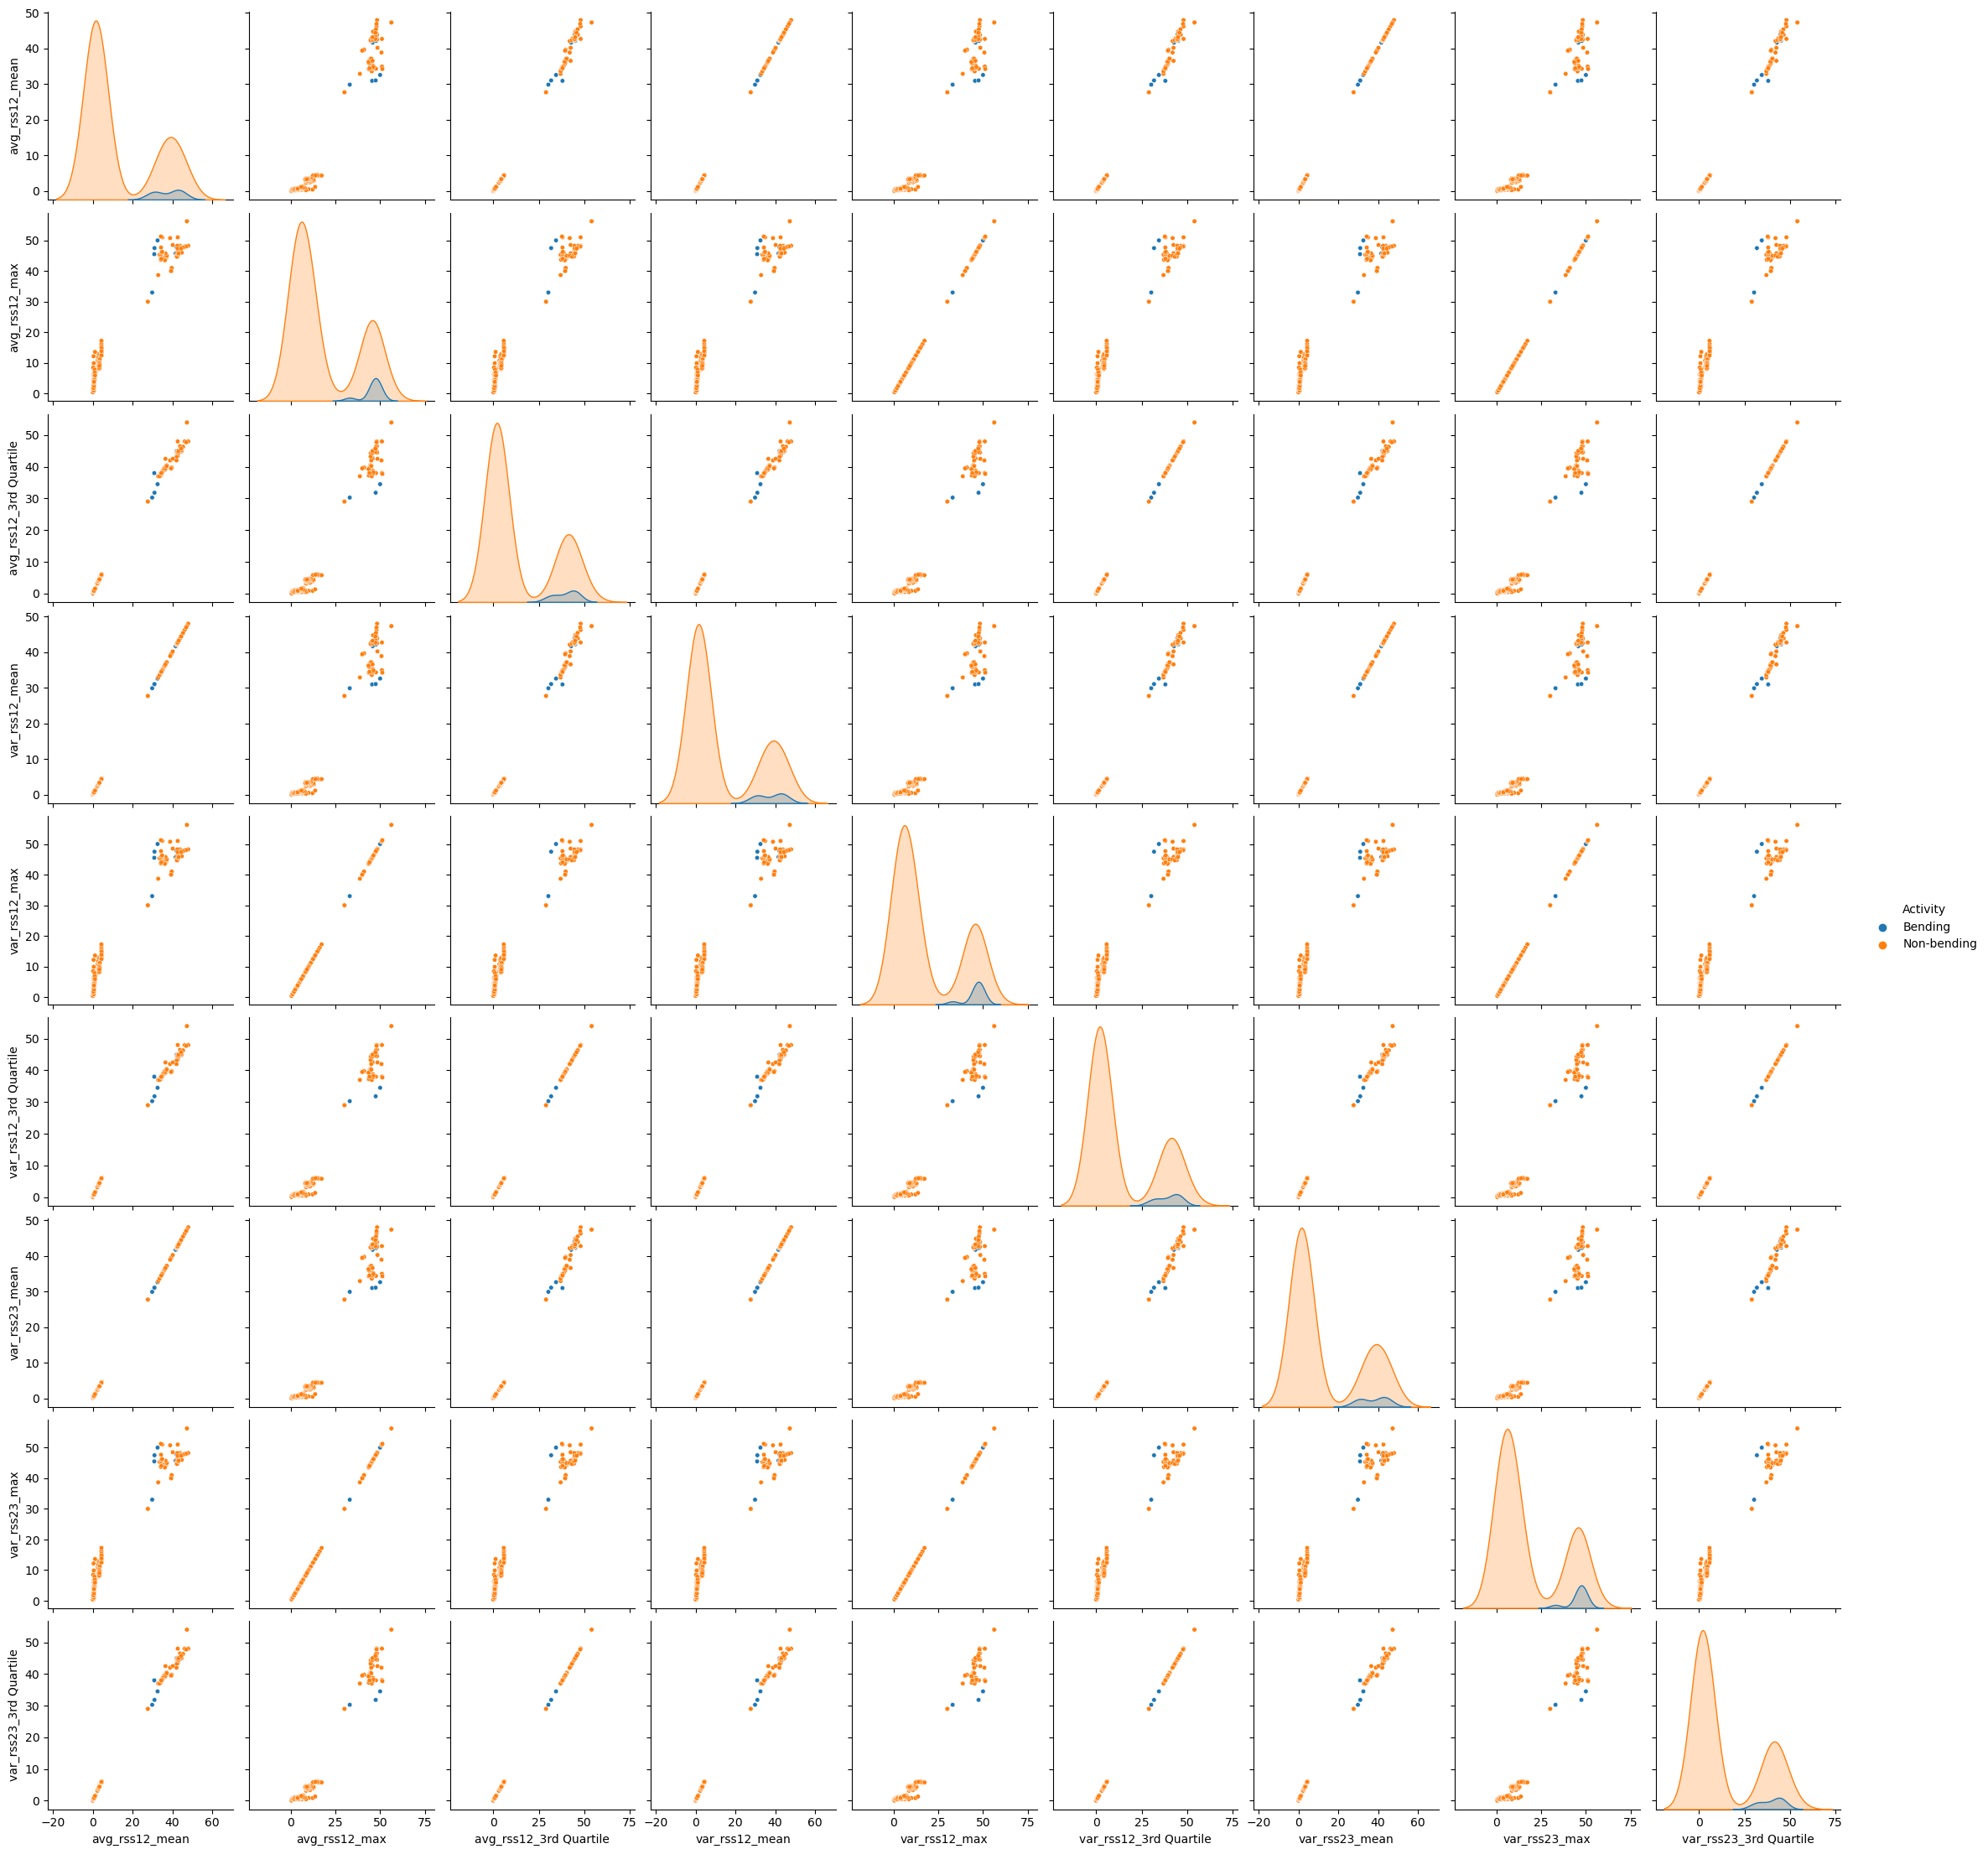

In [17]:
time_series = ['avg_rss12', 'var_rss12', 'var_rss23']
draw_all_scatter_plot(time_series, tr_set)
print(f"The number of features used is: {num_features_used(time_series)}")


#### ii. Splitted Plots
Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [20]:
def segment_time_series(ts, L):
    """
    Segments the time series into L equal-length parts.
    """
    split_indices = np.array_split(range(len(ts)), L)
    return [ts.iloc[index] for index in split_indices]

def extract_features_from_segments(dataset, L, features):
    all_features = []
    for feature in features:
        ts = dataset[feature]
        segments = segment_time_series(ts, L)
        for seg in segments:
            info = pd.Series(seg).describe()
            all_features.extend([info['mean'], info['max'], dataset[feature].quantile(0.75)])
    return all_features

def extract_features(dataset, L, features, data_type='train'):
    feature_data = []
    activities = []

    cnt = 0
    for s in dataset:
        cnt += 1
        feature_data.append(extract_features_from_segments(s, L, features))
        
        if data_type == 'train':
            if cnt <= 9:
                activities.append('Bending')
            else:
                activities.append('Non-bending')
        elif data_type == 'test':
            if cnt <= 4:
                activities.append('Bending')
            else:
                activities.append('Non-bending')

    df = pd.DataFrame(feature_data)
    df['Activity'] = activities
    return df


features = ['avg_rss12', 'var_rss12', 'var_rss23']  # Corresponding to time series 1, 2, and 6
# Which later 0, 1, 5

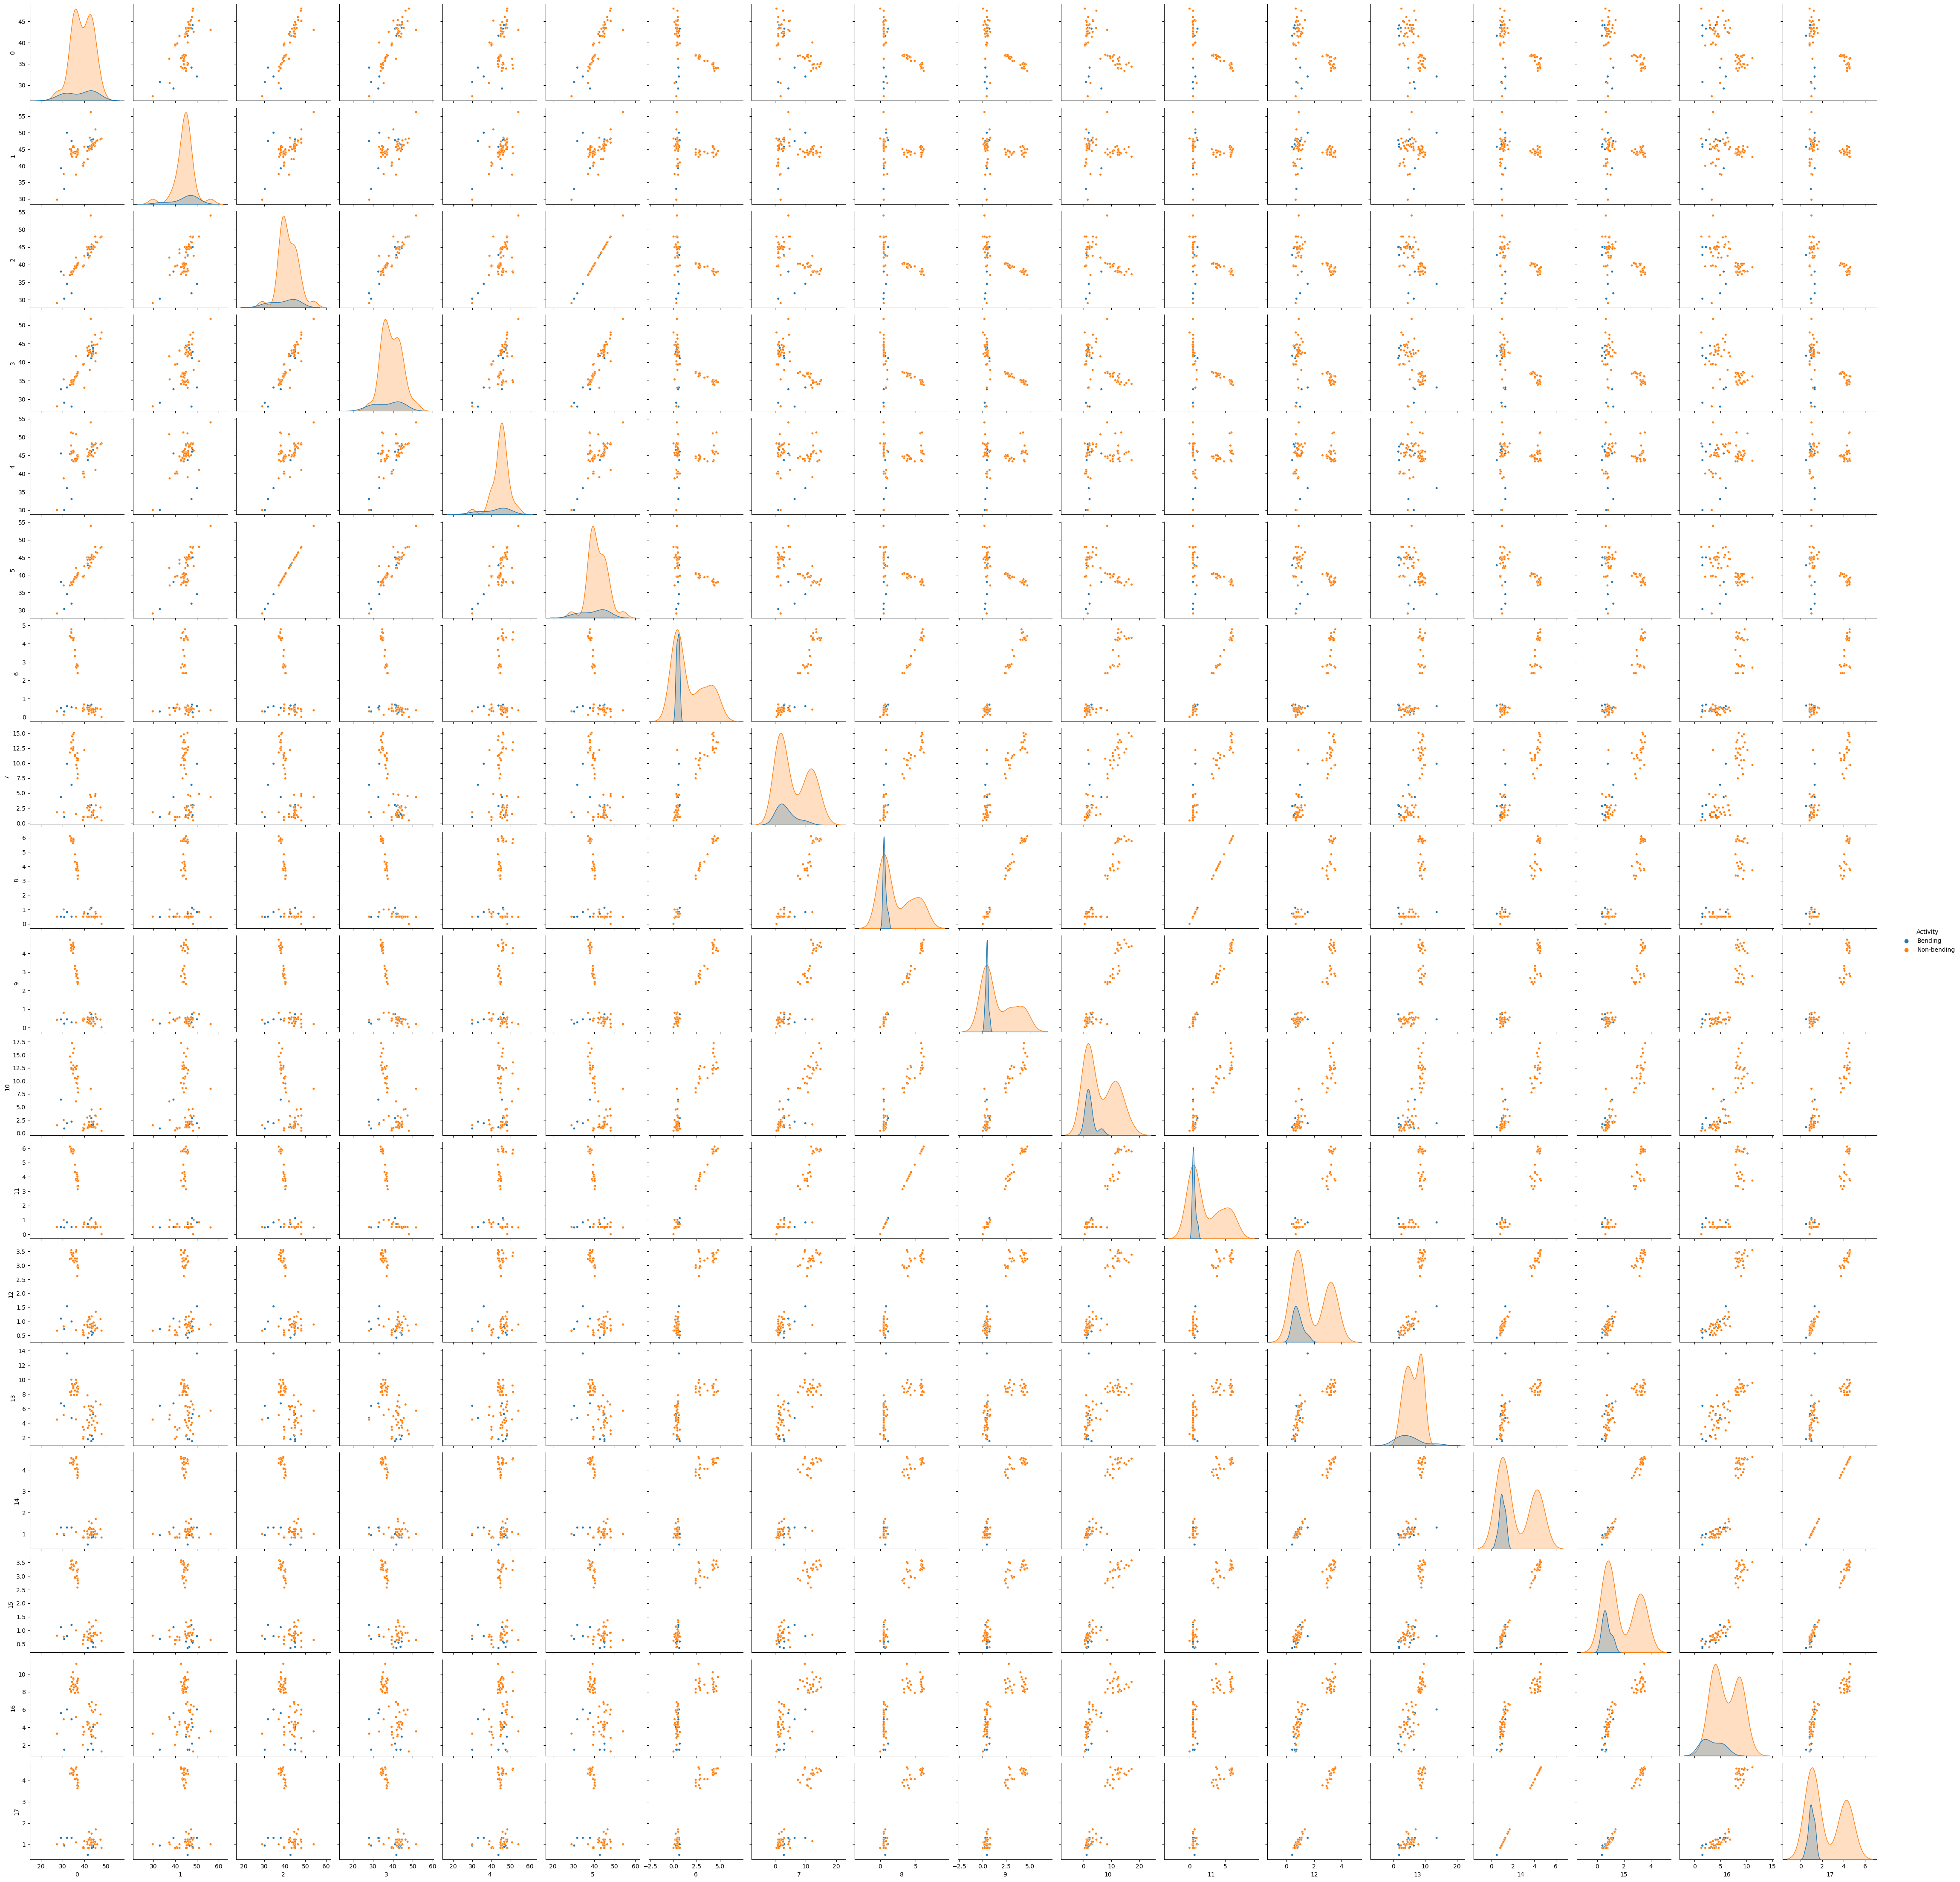

In [21]:
# Breaking into L segments and extracting features
L = 2
df_train = extract_features(tr_set, L, features, data_type='train')

# Plotting scatter plots
sns.pairplot(df_train, hue='Activity', plot_kws={'s':15})


* Visually I do not see much differences betweeen base model versus ploting with the model splited first half and second half in terms of showing different patterns nor seeing clearer clusters than the original.

#### iii. Time Series Segments

In [22]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

for L in range(1, 21):  # or any range you want to test for
    # Extract Features for L segments
    df_train = extract_features(tr_set, L, features, data_type='train')
    X = df_train.drop(columns=['Activity'])
    y = (df_train['Activity'] == 'Bending').astype(int)  # convert to 0 and 1

    # Fit Logistic Regression using sklearn (this step is optional but often useful for cross-validation, etc.)
    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)
    
    # Calculate p-values using statsmodels
    X_with_const = sm.add_constant(X)  # Adding constant for intercept in statsmodels
    try:
        sm_model = sm.Logit(y, X_with_const).fit(disp=0)
        print(f"For L={L}")
        print(sm_model.summary())
        print("="*60)
    except np.linalg.LinAlgError:
        print(f"Couldn't fit model for L={L} due to singular matrix.")
        print("="*60)

Couldn't fit model for L=1 due to singular matrix.
Couldn't fit model for L=2 due to singular matrix.
For L=3
                           Logit Regression Results                           
Dep. Variable:               Activity   No. Observations:                   69
Model:                          Logit   Df Residuals:                       47
Method:                           MLE   Df Model:                           21
Date:                Wed, 11 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        22:02:35   Log-Likelihood:            -1.7859e-07
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 0.0001191
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -58.0380   3.56e+10  -1.63e-09      1.000   -6.98e+10    6.98e+10
0             -3.8152

* It seems having significant multicollinearity in the dataset. So most of P-value loop cannot work.

#### Use 5-fold cross-validation to determine the best value of the pair (l, p), where p is the number of features used in recursive feature elimination

In [23]:
from sklearn.feature_selection import RFECV

for L in range(1, 21):
    # Extract Features for L segments
    df_train = extract_features(tr_set, L, features, data_type='train')
    X = df_train.drop(columns=['Activity'])
    y = (df_train['Activity'] == 'Bending').astype(int)  # convert to 0 and 1

    # Apply RFECV on Logistic Regression
    estimator = LogisticRegression(max_iter=1000)
    selector = RFECV(estimator, step=1, cv=5)
    X_selected = selector.fit_transform(X, y)

    # Extract the cross-validation accuracy for the optimal number of features
    cv_accuracy = selector.cv_results_['mean_test_score'][selector.n_features_ - 1]
    p = selector.n_features_

    print(f"\nNumber of Features for L = {L}, with number of features : {X.shape[1]}")
    print('Cross-Validation Accuracy:', round(cv_accuracy*100, 2),'%')
    print('Optimal number of features:', p)
    print('Selected Features:', X.columns[selector.support_].tolist())  # To display the actual feature names


Number of Features for L = 1, with number of features : 9
Cross-Validation Accuracy: 87.03 %
Optimal number of features: 1
Selected Features: [8]

Number of Features for L = 2, with number of features : 18
Cross-Validation Accuracy: 88.57 %
Optimal number of features: 12
Selected Features: [0, 1, 2, 3, 4, 5, 10, 12, 14, 15, 16, 17]

Number of Features for L = 3, with number of features : 27
Cross-Validation Accuracy: 89.78 %
Optimal number of features: 21
Selected Features: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26]

Number of Features for L = 4, with number of features : 36
Cross-Validation Accuracy: 84.18 %
Optimal number of features: 1
Selected Features: [34]

Number of Features for L = 5, with number of features : 45
Cross-Validation Accuracy: 90.0 %
Optimal number of features: 8
Selected Features: [4, 7, 9, 13, 14, 37, 40, 43]

Number of Features for L = 6, with number of features : 54
Cross-Validation Accuracy: 88.35 %
Optimal number of features:

KeyboardInterrupt: 

#### Explain what the right way and the wrong way are to perform cross-validation in this problem.
> * Using RFECV method with cross-validation is the right way and only possibe way in this case. The p-value method wasn't able to correctly find the solutions maybe due to multicollinearity or over-specified models as seen from the high P-values across all different L s. It might have some situations like more predictors than observations.

#### iv. Confusion Matrix

#### Report the confusion matrix and show the ROC and AUC for your classifier on train data.

* Note :  In principle, fewer features can lead to simpler models which might generalize better. Given all this, while L=7 seems like a good choice since showed good cv-accuracy and not too many number of features.

#### Report the parameters of your logistic regression βi’s as well as the p-values associated with them

Confusion Matrix:
[[60  0]
 [ 0  9]]


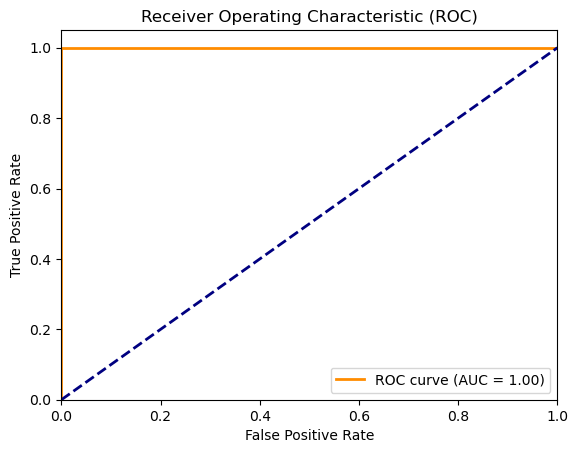

         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [29]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression

# Extract Features for L
L = 7 # Adjust value for any

df_train = extract_features(tr_set, L, features, data_type='train')
X = df_train.drop(columns=['Activity'])
y = (df_train['Activity'] == 'Bending').astype(int)

# Feature selection using RFECV for L
estimator = LogisticRegression(max_iter=10000)
selector = RFECV(estimator, step=1, cv=5)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.support_]

# Fit Logistic Regression using sklearn with selected features
model = LogisticRegression(max_iter=10000)
model.fit(X_selected, y)

# Adjust threshold and predict
threshold = 0.5  # Default is 0.5
y_prob = model.predict_proba(X_selected)[:,1]
y_pred = [1 if prob > threshold else 0 for prob in y_prob]

cm = confusion_matrix(y, y_pred)
print("Confusion Matrix:")
print(cm)

# ROC and AUC
y_prob = model.predict_proba(X_selected)[:,1]
fpr, tpr, thresholds = roc_curve(y, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# the parameters Bi and their p-values using statsmodels
X_selected_with_const = sm.add_constant(pd.DataFrame(X_selected, columns=selected_features))
sm_model = sm.Logit(y, X_selected_with_const).fit()
print(sm_model.summary())


> Bening vs Non-beding is 15% (9/60) and this is considered imbalanced

#### v. Test Classifier

In [27]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# Extract Features for L segments
df_train = extract_features(tr_set, L, features, data_type='train')
X_train = df_train.drop(columns=['Activity'])
y_train = (df_train['Activity'] == 'Bending').astype(int)

df_test = extract_features(te_set, L, features, data_type='test')
X_test = df_test.drop(columns=['Activity'])
y_test = (df_test['Activity'] == 'Bending').astype(int)
X_test

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
0,40.790000,42.00,42.0000,41.967391,42.33,42.0000,40.489275,42.00,42.0000,39.758986,...,1.300,0.743235,1.50,1.300,0.497059,1.87,1.300,0.373676,1.50,1.300
1,43.423913,44.25,43.6700,42.630290,43.67,43.6700,42.150725,42.50,43.6700,41.804348,...,1.300,0.833382,3.11,1.300,0.287353,1.41,1.300,0.337206,1.50,1.300
2,21.155797,24.75,26.5000,23.450580,26.75,26.5000,28.714928,51.00,26.5000,24.983188,...,0.870,0.907500,4.97,0.870,1.004559,4.56,0.870,0.641765,1.66,0.870
3,28.449130,30.00,30.0000,28.951014,30.00,30.0000,29.298261,30.50,30.0000,29.575797,...,1.300,1.104853,3.86,1.300,1.763088,6.76,1.300,1.908235,6.68,1.300
4,36.734348,44.50,40.2500,37.323478,44.00,40.2500,36.382754,45.00,40.2500,37.547391,...,3.900,3.039559,8.18,3.900,2.762647,9.34,3.900,2.684706,8.17,3.900
5,37.476087,43.25,40.2500,37.364348,43.75,40.2500,37.846232,44.00,40.2500,37.422174,...,3.770,2.787941,7.82,3.770,2.949853,7.73,3.770,2.407206,8.83,3.770
6,37.833333,44.00,40.0625,38.121449,44.67,40.0625,37.647681,44.50,40.0625,37.093188,...,4.150,2.985588,7.79,4.150,3.270000,7.50,4.150,3.906471,8.50,4.150
7,28.776667,29.75,29.0000,26.989130,29.75,29.0000,26.729420,29.75,29.0000,26.630435,...,1.000,0.858529,2.50,1.000,0.664265,2.95,1.000,0.910000,3.30,1.000
8,29.094058,30.00,48.0000,40.335652,48.25,48.0000,48.000000,48.00,48.0000,48.016812,...,0.940,0.502941,1.50,0.940,0.387794,1.50,0.940,0.418971,1.25,0.940
9,48.000000,48.00,48.0000,48.000000,48.00,48.0000,48.000000,48.00,48.0000,48.003623,...,0.830,0.604412,1.30,0.830,0.662794,1.30,0.830,0.656912,1.22,0.830


In [30]:
# Apply RFECV on Logistic Regression for train data
estimator = LogisticRegression(max_iter=1000)
selector = RFECV(estimator, step=1, cv=5)
selector.fit(X_train, y_train)

# Transform both train and test data
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

# Fit Logistic Regression using sklearn with selected features from train data
model = LogisticRegression(max_iter=1000)
model.fit(X_train_selected, y_train)

y_pred_prob = model.predict_proba(X_test_selected)[:, 1]
y_pred = [1 if p > threshold else 0 for p in y_pred_prob] # Using the same threshold for Test

# Test Accuracy
test_accuracy = accuracy_score(y_test, y_pred)

# Cross-Validation Accuracy
cv_accuracy = selector.cv_results_['mean_test_score'][selector.n_features_ - 1]

print(f"Cross-Validation Accuracy for L = {L}: {cv_accuracy*100:.2f}%")

print(f"Test Accuracy at ({L},{selector.n_features_}) at threshold of {threshold}: {test_accuracy*100:.2f}%")


Cross-Validation Accuracy for L = 7: 91.43%
Test Accuracy at (7,22) at threshold of 0.5: 94.74%


#### vi. Separation

> It looks like they do have instability since due to incurring many singular matrix erros when there's multicollinearity, the estimation of coefficients becomes unstable. The values we get is seemed to be well-separated.

#### vii. Imbalance

> I can see that the first class has significantly more instances (60) than the second class (9). This is a 60:9 ratio (15%), which clearly suggests an imbalance between the two classes.

### Build a logistic regression model based on case-control sampling and adjust its parameters.

* Lecture note : SMOTE : synthetic minority over-sampling teq is a data sampling procedure that uses both up-sampling and down-sampling, depending on the class 
* SMOTE synthesizes new cases, To do this a data point is randomly selected from the minority class and its K-nearest neighbers (KNN) are determined

Confusion Matrix:
[[15  0]
 [ 1  3]]


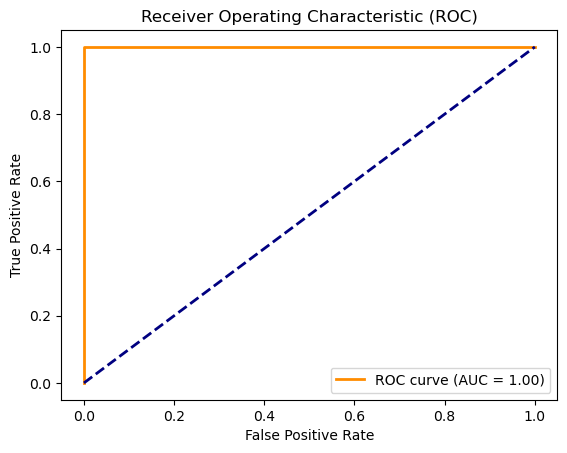

In [31]:
from imblearn.over_sampling import SMOTE

# Extract Features for L segments
df_train = extract_features(tr_set, L, features, data_type='train')
X_train = df_train.drop(columns=['Activity'])
y_train = (df_train['Activity'] == 'Bending').astype(int)

df_test = extract_features(te_set, L, features, data_type='test')
X_test = df_test.drop(columns=['Activity'])
y_test = (df_test['Activity'] == 'Bending').astype(int) 

# Apply SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

# Train a logistic regression model on the resampled data
clf = LogisticRegression(max_iter=1000)
clf.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_pred_prob = clf.predict_proba(X_test)[:,1]
y_pred = [1 if prob > threshold else 0 for prob in y_pred_prob] # adjust this value based on your requirement

# Report Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# ROC and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

> The performance on the minority class (bending) has seen some improvement in terms of reducing false negatives (misclassifying bending as non-bending). However, the true positive rate hasn't improved much (6 before vs. 4 after). Given these results, it seems that while SMOTE may have made the model a bit better at identifying the minority class, it has done so at the expense of its performance on the majority class.

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [32]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

# Define a range of values for l and C to cross-validate over
C_values = np.logspace(-4, 4, 9) # C is inverse Lamda

best_score = 0
best_l = None
best_C = None

scaler = StandardScaler()

for l in range(1, 21) :
    # Extract features based on current l value
    df_train = extract_features(tr_set, L, features, data_type='train')
    X_train_l = df_train.drop(columns=['Activity'])
    y_train_l = (df_train['Activity'] == 'Bending').astype(int)
    
    df_test = extract_features(te_set, L, features, data_type='test')
    X_test_l = df_test.drop(columns=['Activity'])
    y_test_l = (df_test['Activity'] == 'Bending').astype(int)

    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train_l)
    X_test_scaled = scaler.transform(X_test_l)

    # L1-penalized logistic regression with cross-validation for C values
    model_l1 = LogisticRegressionCV(Cs=C_values, cv=5, penalty='l1', solver='liblinear') #l1 is penalty='l1'
    model_l1.fit(X_train_scaled, y_train_l)

    # Score the model on the test set
    score = model_l1.score(X_test_scaled, y_test_l)
    
    # Identify selected features
    coef = model_l1.coef_[0]
    selected_features = X_train_l.columns[coef != 0].tolist()

    # Update best score, l, and C if this score is better than previous best
    if score > best_score:
        best_score = score
        best_l = l
        best_C = model_l1.C_[0]  # This gives the best C value from the cross-validation

    # Print the results for the current iteration
    print(f"Results for l = {l}:")
    print(f"Cross-Validation Score: {model_l1.scores_[1].mean()*100:.2f}%")
    print(f"Selected Non-Zero features: {selected_features}")
    print(f"Test Accuracy: {score*100:.2f}%")
    print(f"Optimal C value: {model_l1.C_[0]}")
    print("-----------------------------------------------------------")

print("\nBest Results:")
print(f"Best l value: {best_l}")
print(f"Best C value: {best_C}")
print(f"Best accuracy: {best_score*100:.2f}%")


Results for l = 1:
Cross-Validation Score: 86.06%
Selected Non-Zero features: [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 25, 43, 49, 52, 55, 58, 60, 61]
Test Accuracy: 89.47%
Optimal C value: 100.0
-----------------------------------------------------------
Results for l = 2:
Cross-Validation Score: 86.06%
Selected Non-Zero features: [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 25, 43, 49, 52, 55, 58, 60, 61]
Test Accuracy: 94.74%
Optimal C value: 100.0
-----------------------------------------------------------
Results for l = 3:
Cross-Validation Score: 85.89%
Selected Non-Zero features: [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 25, 43, 49, 52, 55, 58, 60, 61]
Test Accuracy: 89.47%
Optimal C value: 100.0
-----------------------------------------------------------
Results for l = 4:
Cross-Validation Score: 85.24%
Selected Non-Zero features: [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 14, 15, 16, 17, 19, 20, 25, 43, 49, 52, 55, 58, 60, 61]
Test Accuracy

#### ii. Comparison

> L1-Penalized Regression performs better and much quicker since some insignificant coeffiecients are automatically shrunk to zero. P-Value method is very computationally cumbersome and sensitive to multicollinearity. Meanwhile, L1-Penalized Regression does have better test accuracies across all the Ls in this case as well.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [33]:
def extract_all_features(dataset, L, features, data_type='train'):
    feature_data = []
    activities = []

    # Considering the sequence you provided during data loading
    activity_labels = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
    # Index at which each activity starts in the dataset
    activity_start_indices = {
        'train': [1, 6, 10, 22, 34, 46, 58],
        'test': [1, 3, 5, 8, 11, 14, 17]
    }
    
    cnt = 0
    for s in dataset:
        cnt += 1
        feature_data.append(extract_features_from_segments(s, L, features))
        
        # Check activity based on count and data type
        if cnt < activity_start_indices[data_type][1]:
            activities.append('bending1')
        elif cnt < activity_start_indices[data_type][2]:
            activities.append('bending2')
        elif cnt < activity_start_indices[data_type][3]:
            activities.append('cycling')
        elif cnt < activity_start_indices[data_type][4]:
            activities.append('lying')
        elif cnt < activity_start_indices[data_type][5]:
            activities.append('sitting')
        elif cnt < activity_start_indices[data_type][6]:
            activities.append('standing')
        else:
            activities.append('walking')
            
    df = pd.DataFrame(feature_data)
    df['Activity'] = activities
    return df


L = 1 # Reset the L

In [34]:
df_train = extract_all_features(tr_set, L, features, data_type='train')
'''pd.set_option('display.max_rows', None)''' # Just to check classification columns are correct.
df_train

,0,1,2,3,4,5,6,7,8,Activity
0,43.954500,47.40,45.0000,0.426250,1.70,0.5000,0.493292,1.79,0.9400,bending1
1,42.179812,47.75,45.0000,0.696042,3.00,1.1200,0.613521,2.18,1.0000,bending1
2,41.678063,45.75,42.7500,0.535979,2.83,0.7100,0.383292,1.79,0.5000,bending1
3,43.454958,48.00,45.0000,0.378083,1.58,0.5000,0.679646,5.26,0.8700,bending1
4,43.969125,48.00,44.6700,0.413125,1.50,0.5000,0.555312,2.96,0.8300,bending1
...,...,...,...,...,...,...,...,...,...,...
64,33.586875,45.33,37.0000,4.576562,14.67,6.1050,3.259729,8.32,4.3225,walking
65,34.322750,45.50,38.0000,4.456333,13.47,5.9700,3.432563,9.67,4.5650,walking
66,34.546229,46.00,37.8125,4.371958,12.47,5.8000,3.338125,10.00,4.3350,walking
67,34.873229,46.25,38.2500,4.380583,14.82,5.9325,3.424646,9.51,4.5000,walking


In [35]:
df_test = extract_all_features(te_set, L, features, data_type='test')
df_test

,0,1,2,3,4,5,6,7,8,Activity
0,40.624792,45.00,42.0000,0.358604,1.30,0.5000,0.570583,1.92,1.300,bending1
1,42.812812,45.67,43.6700,0.372437,1.22,0.5000,0.571083,3.11,1.300,bending1
2,24.562958,51.00,26.5000,0.590833,6.87,0.7100,0.700188,4.97,0.870,bending2
3,27.464604,42.75,30.0000,0.449708,7.76,0.5000,1.122125,6.76,1.300,bending2
4,37.177042,45.00,40.2500,2.374208,8.58,3.1300,2.921729,9.34,3.900,cycling
5,37.561187,44.75,40.2500,2.080687,9.91,2.8700,2.765896,9.62,3.770,cycling
6,37.058708,44.67,40.0625,2.438146,14.17,3.3500,2.983750,8.55,4.150,cycling
7,27.716375,30.00,29.0000,0.363687,1.79,0.5000,0.734271,4.50,1.000,lying
8,44.182937,48.33,48.0000,0.101875,3.11,0.0000,0.692771,3.91,0.940,lying
9,48.004167,48.25,48.0000,0.007167,0.43,0.0000,0.641229,2.50,0.830,lying


In [36]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score

# Define a range of values for l and C to cross-validate over
C_values = np.logspace(-4, 4, 9) # C is inverse Lamda

L_values = list(range(1, 21))
cv_scores = []

for L in L_values:
    # Extract features using the current value of L
    df_train = extract_all_features(tr_set, L, features, data_type='train')
    X_train_l = df_train.drop(columns=['Activity'])
    y_train_l = df_train['Activity']
    
    # Scale the data
    X_train_scaled = scaler.fit_transform(X_train_l)

    # Build L1-penalized multinomial logistic regression model
    multimodel_l1 = LogisticRegressionCV(Cs=C_values, penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000, cv=5)
    multimodel_l1.fit(X_train_scaled, y_train_l)
    
    # Get the names of the selected features (non-zero coefficients)
    selected_features = np.where(multimodel_l1.coef_[0] != 0)[0]
    
    # Store mean of cross-validation scores
    score = np.mean(cross_val_score(multimodel_l1, X_train_scaled, y_train_l, cv=5))
    cv_scores.append(score)

    # Print the results
    print(f"Results for l = {L}:")
    unique_classes = multimodel_l1.classes_

    mean_scores = np.mean([value.mean() for value in multimodel_l1.scores_.values()])
    print(f"Average Cross-Validation Score: {mean_scores*100:.2f}%")
    print(f"Selected Non-Zero features: {selected_features}")
    print(f"Training Accuracy: {score*100:.2f}%")
    print(f"Optimal C value: {multimodel_l1.C_[0]}")
    print("-----------------------------------------------------------")

# Identify the best L based on cross-validation scores
best_L = L_values[np.argmax(cv_scores)]
print(f"The best L value is: {best_L}")

Results for l = 1:
Average Cross-Validation Score: 46.72%
Selected Non-Zero features: [0 1 2 3 4 5 6 7 8]
Training Accuracy: 69.67%
Optimal C value: 1000.0
-----------------------------------------------------------
Results for l = 2:
Average Cross-Validation Score: 46.35%
Selected Non-Zero features: [ 1  2  4  5  9 10 13 14 15 16 17]
Training Accuracy: 69.89%
Optimal C value: 10.0
-----------------------------------------------------------
Results for l = 3:
Average Cross-Validation Score: 46.62%
Selected Non-Zero features: [ 0  1  2  4  5  6  7  8 15 18 22 24 25]
Training Accuracy: 66.81%
Optimal C value: 10.0
-----------------------------------------------------------
Results for l = 4:
Average Cross-Validation Score: 46.04%
Selected Non-Zero features: [ 0  1  2  3  4  5  6  7  8  9 10 11 14 15 16 17 18 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35]
Training Accuracy: 63.63%
Optimal C value: 100.0
-----------------------------------------------------------
Results for l = 5:
Aver

### Report your test error.

In [37]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Extract features using the best value of L for training data
df_train_best_L = extract_all_features(tr_set, best_L, features, data_type='train')
X_train_best_L = df_train_best_L.drop(columns=['Activity'])
y_train_best_L = df_train_best_L['Activity']

# Fit the model with the scaled training data
multimodel_best_l1 = LogisticRegressionCV(Cs=10, penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000, cv=5)
multimodel_best_l1.fit(X_train_best_L, y_train_best_L)

# Extract features using the best value of L for test data
df_test = extract_all_features(te_set, best_L, features, data_type='test')
X_test_l = df_test.drop(columns=['Activity'])
y_test_l = df_test['Activity']

# Predict with the previously trained model with the best L value
y_pred = multimodel_best_l1.predict(X_test_l)

# Calculate the test accuracy and error
test_accuracy = accuracy_score(y_test_l, y_pred)
test_error = 1 - test_accuracy

# Print the results
print(f"Results for L = {best_L} on Test Data:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Error: {test_error*100:.2f}%")
print("-----------------------------------------------------------")


Results for L = 5 on Test Data:
Test Accuracy: 57.89%
Test Error: 42.11%
-----------------------------------------------------------


* Do this again for standard scaled data

In [38]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score

# Scaled data

# Extract features using the best value of L for training data
df_train_best_L = extract_all_features(tr_set, best_L, features, data_type='train')
X_train_best_L = df_train_best_L.drop(columns=['Activity'])
y_train_best_L = df_train_best_L['Activity']

# Scale the training data
scaler.fit(X_train_best_L)
X_train_best_scaled_l = scaler.transform(X_train_best_L)

# Fit the model with the scaled training data
multimodel_best_l1 = LogisticRegressionCV(Cs=10, penalty='l1', solver='saga', multi_class='multinomial', max_iter=1000, cv=5)
multimodel_best_l1.fit(X_train_best_scaled_l, y_train_best_L)

# Extract features using the best value of L for test data
df_test = extract_all_features(te_set, best_L, features, data_type='test')
X_test_l = df_test.drop(columns=['Activity'])
y_test_l = df_test['Activity']

# Scale the test data using the same scaler
X_test_scaled = scaler.transform(X_test_l)

# Predict with the previously trained model with the best L value
y_pred = multimodel_best_l1.predict(X_test_scaled)

# Calculate the test accuracy and error
test_accuracy = accuracy_score(y_test_l, y_pred)
test_error = 1 - test_accuracy

# Print the results
print(f"Results for L = {best_L} on Scaled Test Data:")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Error: {test_error*100:.2f}%")
print("-----------------------------------------------------------")


Results for L = 5 on Scaled Test Data:
Test Accuracy: 57.89%
Test Error: 42.11%
-----------------------------------------------------------


* Scaled dataset performs slightly better

### Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

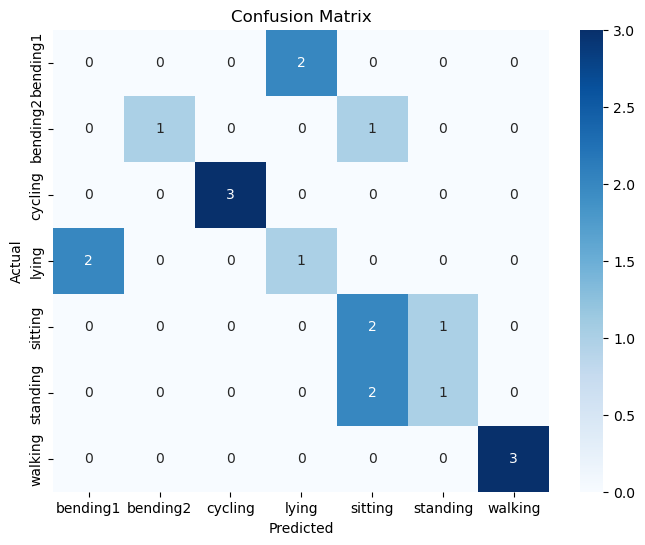

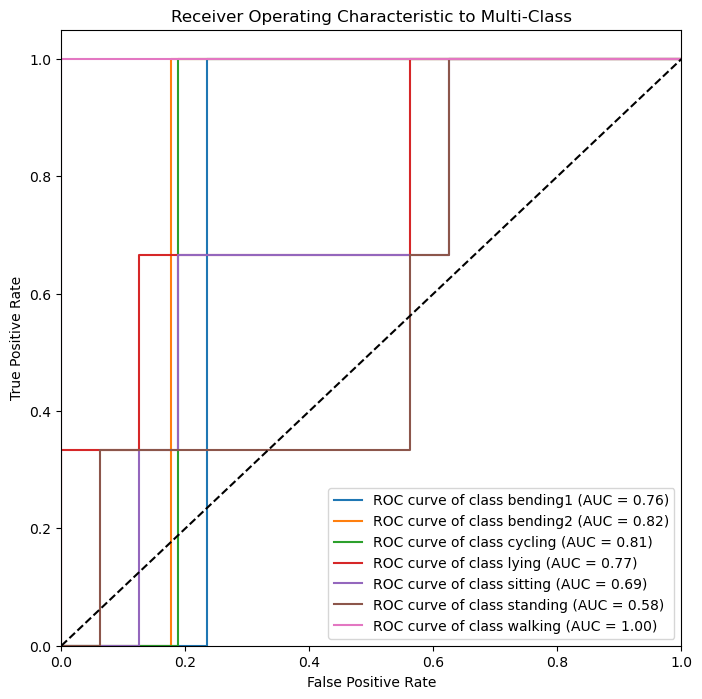

In [39]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Compute Confusion Matrix
confusion = confusion_matrix(y_test_l, y_pred)

# Plot Confusion Matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap=plt.cm.Blues, 
            xticklabels=multimodel_best_l1.classes_, 
            yticklabels=multimodel_best_l1.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve and AUC for each class
y_test_bin = label_binarize(y_test_l, classes=multimodel_best_l1.classes_)
n_classes = y_test_bin.shape[1]
y_score = multimodel_best_l1.decision_function(X_test_scaled)

# ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"ROC curve of class {multimodel_best_l1.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic to Multi-Class')
plt.legend(loc="lower right")
plt.show()

#### ii. Naive Bayes

* Use unscaled data (otherwise it puts out error)

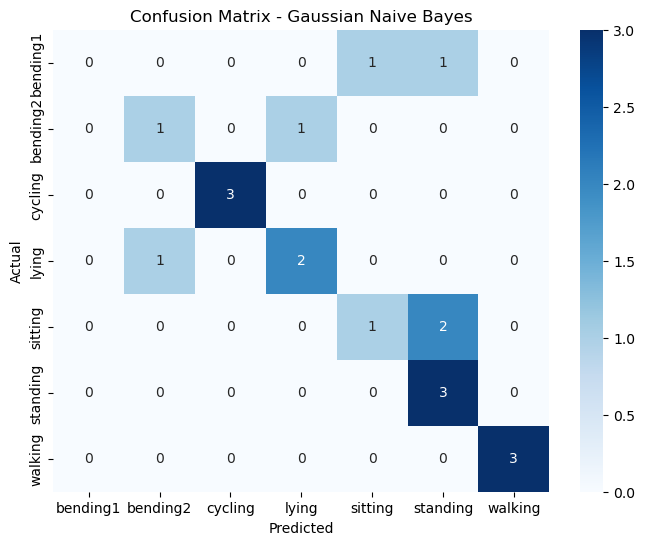

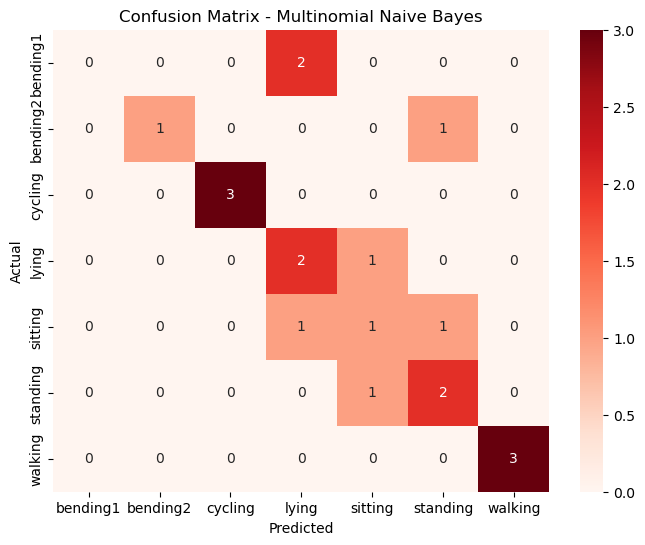

In [40]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

# Train the Gaussian Naïve Bayes classifier
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train_best_L, y_train_best_L)
y_pred_gaussian = gaussian_nb.predict(X_test_l)

# Train the Multinomial Naïve Bayes classifier
multinomial_nb = MultinomialNB()
multinomial_nb.fit(X_train_best_L, y_train_best_L)

# Test Prediction
y_pred_multinomial = multinomial_nb.predict(X_test_l)

# Evaluate the Gaussian Naïve Bayes classifier
confusion_gaussian = confusion_matrix(y_test_l, y_pred_gaussian)

# Evaluate the Multinomial Naïve Bayes classifier
confusion_multinomial = confusion_matrix(y_test_l, y_pred_multinomial)

# Plot Confusion Matrix for Gaussian Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_gaussian, annot=True, fmt="d", cmap=plt.cm.Blues, 
            xticklabels=gaussian_nb.classes_, 
            yticklabels=gaussian_nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()

# Plot Confusion Matrix for Multinomial Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_multinomial, annot=True, fmt="d", cmap=plt.cm.Reds, 
            xticklabels=multinomial_nb.classes_, 
            yticklabels=multinomial_nb.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix - Multinomial Naive Bayes")
plt.show()


* For ROC & AUC plots

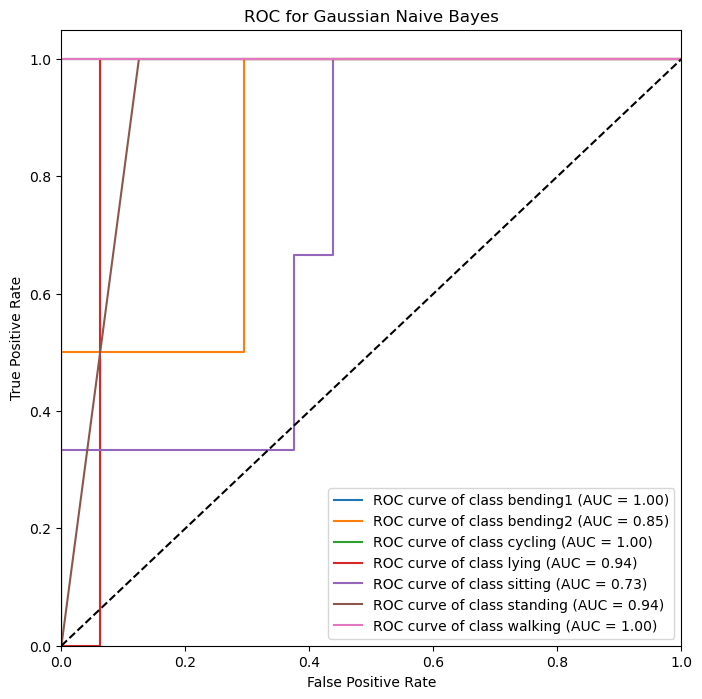

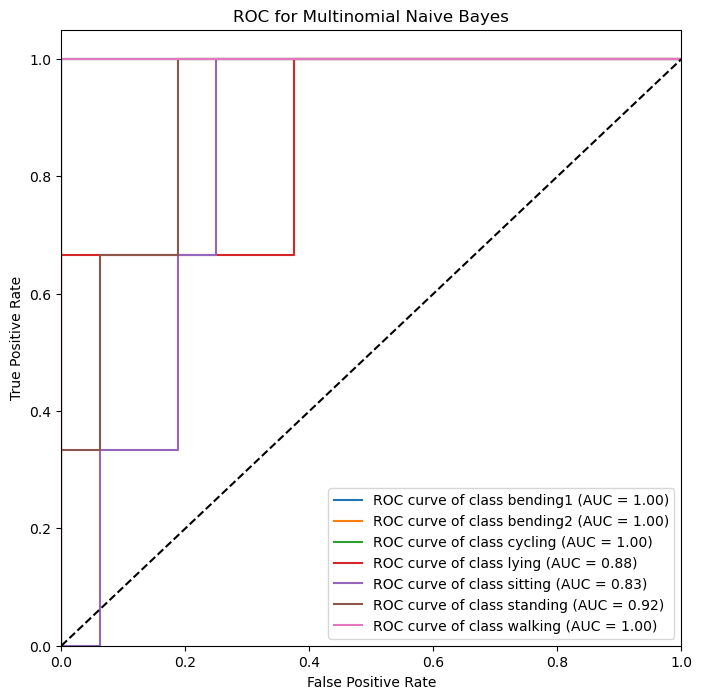

In [41]:
from sklearn.metrics import roc_curve, auc

# Get probability estimates for ROC computation
y_score_gaussian = gaussian_nb.predict_proba(X_test_l)
y_score_multinomial = multinomial_nb.predict_proba(X_test_l)

# Compute ROC curve and AUC for Gaussian Naïve Bayes
fpr_gaussian = dict()
tpr_gaussian = dict()
roc_auc_gaussian = dict()
for i in range(n_classes):
    fpr_gaussian[i], tpr_gaussian[i], _ = roc_curve(y_test_bin[:, i], y_score_gaussian[:, i])
    roc_auc_gaussian[i] = auc(fpr_gaussian[i], tpr_gaussian[i])

# Compute ROC curve and AUC for Multinomial Naïve Bayes
fpr_multinomial = dict()
tpr_multinomial = dict()
roc_auc_multinomial = dict()
for i in range(n_classes):
    fpr_multinomial[i], tpr_multinomial[i], _ = roc_curve(y_test_bin[:, i], y_score_multinomial[:, i])
    roc_auc_multinomial[i] = auc(fpr_multinomial[i], tpr_multinomial[i])

# Plot ROC curves for Gaussian Naïve Bayes
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr_gaussian[i], tpr_gaussian[i], label=f"ROC curve of class {gaussian_nb.classes_[i]} (AUC = {roc_auc_gaussian[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Gaussian Naive Bayes')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curves for Multinomial Naïve Bayes
plt.figure(figsize=(8, 8))
for i in range(n_classes):
    plt.plot(fpr_multinomial[i], tpr_multinomial[i], label=f"ROC curve of class {multinomial_nb.classes_[i]} (AUC = {roc_auc_multinomial[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Multinomial Naive Bayes')
plt.legend(loc="lower right")
plt.show()


#### ii. Comparison

> 1. bending activities: All classifiers struggle with distinguishing between bending1 and bending2. However, the Gaussian Naive Bayes misclassifies bending activities to a wider variety of other activities, while the Multinomial version mostly confuses between the two bending types. Logistic Regression did the slightly better result among the others.
> 2. cycling and walking: All classifiers perform perfectly for these two activities.
> 3. lying and sitting: All classifiers exhibit similar behavior where they tend to confuse "lying" with "sitting" and vice versa.
> 4. standing: all classifiers did well with only minor errors.
> * None of the classifier is perfect, but by looking at ROC plot and AUC, it seems like the Logistic regression might be a bit more reliable for this dataset.

## 3. ISLR 4.8.3

## 4. ISLR 4.8.7

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9